# Load file
D:\github\2H_TaSe2_Tc_STM\getPhasemap.ipynb

In [16]:
import pickle
with open('dataCache/pa.pkl','rb') as f:
    pa = pickle.load(f)
with open('dataCache/hddf.pkl','rb') as f:
    df = pickle.load(f)

In [17]:
from imagingPhase import visPhase as vp
from matplotlib import pyplot as plt

In [18]:
import importlib
importlib.reload(vp)

<module 'imagingPhase.visPhase' from 'd:\\github\\2H_TaSe2_Tc_STM\\imagingPhase\\visPhase.py'>

In [19]:
phiPrinters = []
for idt in range(len(df)):
    print(idt)
    phiPrinters.append(vp.phiPrinter(pa[0][idt]))

0
phase uploaded
phase calculated
1
phase uploaded
phase calculated
2
phase uploaded
phase calculated
3
phase uploaded
phase calculated
4
phase uploaded
phase calculated


In [20]:
# The 'isb' column is created to store the original index order 




In [21]:
df['idt'] = range(len(df))
df['phiPrinter'] = phiPrinters
df = df.sort_values(by='isb').reset_index(drop=True)

# Visualization

In [22]:
def subplotss(nm_rows, nm_cols, nm_sup='sup', figsize=(10, 6), **kwargs):
    """
    Wrapper function for plt.subplots
    
    Parameters:
    -----------
    nm_rows : list
        List of ylabel for each row
    nm_cols : list  
        List of title for each column
    nm_sup : str, default='sup'
        Suptitle for the entire figure
    figsize : tuple, default=(10, 6)
        Figure size
    **kwargs : 
        Additional arguments to pass to plt.subplots (sharex, sharey, subplot_kw, etc.)
    
    Returns:
    --------
    fig, axs : matplotlib figure and axes objects
    """
    # Create subplots using lengths of nm_rows and nm_cols
    nrows, ncols = len(nm_rows), len(nm_cols)
    
    # Pass all arguments to plt.subplots
    fig, axs = plt.subplots(nrows, ncols, figsize=figsize, **kwargs)
    
    # Set suptitle
    plt.suptitle(nm_sup)
    
    # Convert to 2D array if axs is 1D (for single row/column cases)
    if nrows == 1:
        axs = axs.reshape(1, -1)
    elif ncols == 1:
        axs = axs.reshape(-1, 1)
    elif nrows == 1 and ncols == 1:
        axs = np.array([[axs]])
    
    # Set ylabel for each row (only on the first column)
    for i, row_label in enumerate(nm_rows):
        axs[i, 0].set_ylabel(row_label)
    
    # Set title for each column (only on the first row)
    for j, col_label in enumerate(nm_cols):
        axs[0, j].set_title(col_label)
    
    return fig, axs

In [23]:
nm_HACs = ['HC','AC','CC']  
import numpy as np
foo = [[df['phiPrinter'][isb].BaryHAC[:,:,ihac] for isb in range(len(df))] 
     for ihac in range(len(nm_HACs))]
foo2 = np.array(foo,dtype=object)

In [24]:
def _prepare_broadcastable_arg(arg, target_shape):
    """(이전과 동일한 헬퍼 함수)"""
    m, n = target_shape
    np_arg = np.array(arg, dtype=object)

    if np_arg.ndim == 1:
        if np_arg.shape[0] == n:
            np_arg = np_arg.reshape(1, n)
        elif np_arg.shape[0] == m:
            np_arg = np_arg.reshape(m, 1)

    try:
        return np.broadcast_to(np_arg, target_shape)
    except ValueError:
        print(f"Warning: The provided argument with shape {np.shape(arg)} could not be broadcast to {target_shape}. Treating as a single element.")
        arg_as_scalar = np.empty((1, 1), dtype=object)
        arg_as_scalar[0, 0] = np_arg

        # arg_as_scalar = np.array([[arg]], dtype=object)
        print(arg_as_scalar.shape)
        return np.broadcast_to(arg_as_scalar, target_shape)

def broad_plot(axs, dts, draws):
    """
    여러 axes에 데이터와 그리기 함수를 브로드캐스팅하여 그림을 그립니다. (수정된 버전)
    """
    if not isinstance(axs, np.ndarray):
        axs = np.array(axs)
    
    target_shape = axs.shape
    broadcasted_dts = _prepare_broadcastable_arg(dts, target_shape)
    broadcasted_draws = _prepare_broadcastable_arg(draws, target_shape)

    for i, j in np.ndindex(target_shape):
        ax = axs[i, j]
        dt = broadcasted_dts[i, j]
        draw_func = broadcasted_draws[i, j]
        
        # 💡 변경된 부분: ax를 직접 인자로 전달
        draw_func(ax, dt)

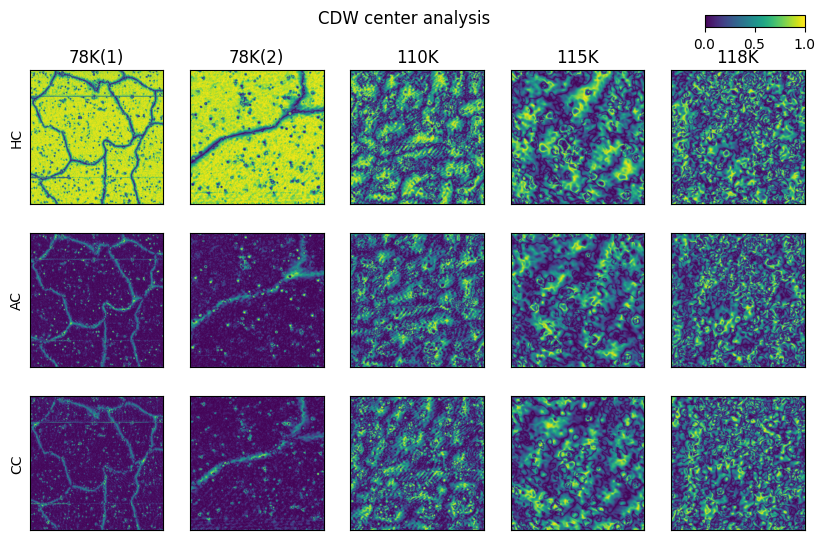

In [34]:
from useful import *
fig,axs = subplotss(nm_HACs,df['nms'],nm_sup='CDW center analysis')
def mshow(ax,dt):
    ax.imshow(dt)
    ax.set_xticks([])
    ax.set_yticks([])
broad_plot(axs,foo2,mshow)
add_colorbar(fig,clim=[0,1])

In [35]:
import numpy as np
import matplotlib.pyplot as plt

def apply_ternary_colormap(
    data_array,
    color1=(1, 0, 0),  # v1=1에 해당하는 색상 (기본값: Red)
    color2=(0, 1, 0),  # v2=1에 해당하는 색상 (기본값: Green)
    color3=(0, 0, 1)   # v3=1에 해당하는 색상 (기본값: Blue)
):
    """
    (H, W, 3) 형태의 바리센트릭 좌표 배열에 터너리 컬러맵을 적용합니다.

    Args:
        data_array (np.ndarray): (H, W, 3) 형태의 입력 배열.
                                 마지막 축은 (v1, v2, v3) 값을 가집니다.
        color1 (tuple): v1에 해당하는 RGB 색상.
        color2 (tuple): v2에 해당하는 RGB 색상.
        color3 (tuple): v3에 해당하는 RGB 색상.

    Returns:
        np.ndarray: (H, W, 3) 형태의 RGB 색상 배열.
    """
    # 입력 데이터에서 v1, v2, v3 좌표를 분리합니다.
    v1 = data_array[..., 0]
    v2 = data_array[..., 1]
    v3 = data_array[..., 2]

    # 입력된 색상 핸들을 numpy 배열로 변환합니다.
    c1 = np.array(color1)
    c2 = np.array(color2)
    c3 = np.array(color3)

    # 브로드캐스팅을 위해 v1,v2,v3의 차원을 (H,W) -> (H,W,1)로 확장하고
    # 각 색상과 곱한 뒤 모두 더하여 최종 RGB 값을 계산합니다.
    rgb_array = (v1[..., np.newaxis] * c1 +
                 v2[..., np.newaxis] * c2 +
                 v3[..., np.newaxis] * c3)

    # 부동소수점 오차 등으로 인해 값이 0~1 범위를 벗어날 경우를 대비해 clip 처리합니다.
    return np.clip(rgb_array, 0, 1)

In [ ]:
isb = 0
df['phiPrinters'][isb]

KeyError: "None of [Index([<imagingPhase.visPhase.phiPrinter object at 0x0000027212D38590>,\n       <imagingPhase.visPhase.phiPrinter object at 0x0000027202B1FEF0>,\n       <imagingPhase.visPhase.phiPrinter object at 0x0000027202D2E150>,\n       <imagingPhase.visPhase.phiPrinter object at 0x0000027202C1AB70>,\n       <imagingPhase.visPhase.phiPrinter object at 0x0000027212C8E150>],\n      dtype='object')] are in the [columns]"

In [ ]:
plt.figure(figsize=[10,10])
apply_ternary_colormap(foo[],color1=[0,1,1],color2=[1,0,1],color3=[1,1,0]) 


TypeError: list indices must be integers or slices, not tuple

<Figure size 1000x1000 with 0 Axes>

In [37]:
from skimage.transform import resize

# Define the new size, for example, half of the original dimensions
new_shape = (foo.shape[0] // 10, foo.shape[1] // 10)

# Resize the array. anti_aliasing=True is recommended for down-sampling.
foo = resize(foo, new_shape, anti_aliasing=True)

print(f"New shape of foo: {foo.shape}")

AttributeError: 'list' object has no attribute 'shape'

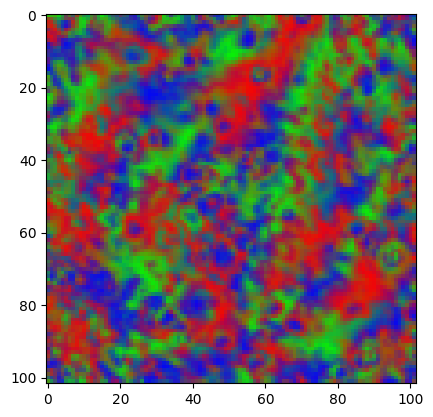

In [ ]:
plt.imshow(foo)

In [ ]:
import plotly.figure_factory as ff
import numpy as np
Al = np.array([0. , 0. , 0., 0., 1./3, 1./3, 1./3, 2./3, 2./3, 1.])
Cu = np.array([0., 1./3, 2./3, 1., 0., 1./3, 2./3, 0., 1./3, 0.])
# Al = foo[:,:,1].flatten() #
# Cu = foo[:,:,2].flatten()
Y = 1 - Al - Cu
# synthetic data for mixing enthalpy
# See https://pycalphad.org/docs/latest/examples/TernaryExamples.html
enthalpy = 2.e6 * (Al - 0.01) * Cu * (Al - 0.52) * (Cu - 0.48) * (Y - 1)**2 - 5000
fig = ff.create_ternary_contour(np.array([Al, Y, Cu]), Al,
                                pole_labels=['Al', 'Y', 'Cu'],
                                interp_mode='cartesian',
                                ncontours=20,
                                colorscale='Viridis',
                                showscale=True,
                                title=dict(
                                  text='Mixing enthalpy of ternary alloy'
                                ))

In [ ]:
fig

In [ ]:
import numpy as np

import matplotlib.pyplot as plt
# import mpltern

np.random.seed(19680801)
t, l, r = np.random.dirichlet(alpha=(2.0, 4.0, 8.0), size=100000).T

In [ ]:
ft = plt.figure()
ax = plt.subplot(projection="ternary")

# If "edgecolors=face" (default), small hexagons look overlapping.
ax.hexbin(foo[:,:,0].flatten(), foo[:,:,1].flatten(), foo[:,:,2].flatten(), edgecolors="none",gridsize=20)



ValueError: Unknown projection 'ternary'

<Figure size 640x480 with 0 Axes>

In [ ]:
import numpy as np
import matplotlib.pyplot as plt

def create_triangle_ternary_map(
    size=512,
    color1=(1, 0, 0),  # v1=1 일 때의 색상 (기본값: Red)
    color2=(0, 1, 0),  # v2=1 일 때의 색상 (기본값: Green)
    color3=(0, 0, 1)   # v3=1 일 때의 색상 (기본값: Blue)
):
    """
    정삼각형 터너리 컬러맵을 생성합니다.
    세 꼭짓점(v1, v2, v3)의 색상을 직접 지정할 수 있습니다.
    """
    # 1. 좌표계 설정 및 바리센트릭 좌표 계산 (이전과 동일)
    height_to_width_ratio = np.sqrt(3)/2
    x_coords = np.linspace(0, 1, size)
    y_coords = np.linspace(height_to_width_ratio, 0, size)
    xv, yv = np.meshgrid(x_coords, y_coords)
    
    v3_bary = yv / height_to_width_ratio
    v2_bary = xv - v3_bary * 0.5
    v1_bary = 1 - v2_bary - v3_bary

    # 2. 삼각형 내부 영역 마스크 생성 (이전과 동일)
    mask = (v1_bary >= -1e-6) & (v2_bary >= -1e-6) & (v3_bary >= -1e-6)
    
    # --- 핵심 수정 부분: 선형 보간 ---
    # 3. 입력된 색상 핸들을 numpy 배열로 변환
    c1 = np.array(color1)
    c2 = np.array(color2)
    c3 = np.array(color3)

    # 4. 바리센트릭 좌표를 가중치로 사용하여 색상을 선형 보간
    # 브로드캐스팅을 위해 v1, v2, v3의 차원을 확장 (size, size) -> (size, size, 1)
    rgb = (v1_bary[..., np.newaxis] * c1 +
           v2_bary[..., np.newaxis] * c2 +
           v3_bary[..., np.newaxis] * c3)
    # ---------------------------------

    # 5. RGBA 이미지 생성 (이전과 동일)
    rgba = np.zeros((size, size, 4))
    rgba[mask, :3] = np.clip(rgb[mask], 0, 1)
    rgba[mask, 3] = 1.0

    return rgba, height_to_width_ratio

# --- 예제 1: 기본값 (v1=R, v2=G, v3=B) 사용 ---
default_map, ratio = create_triangle_ternary_map()

fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(14, 7))
fig.set_facecolor('#DDDDDD')

ax1.imshow(default_map, extent=[0, 1, 0, ratio])
ax1.set_aspect('equal', adjustable='box')
ax1.set_title('Default Handles (v1:R, v2:G, v3:B)', fontsize=14)
ax1.axis('off')
ax1.text(0.5, ratio, 'V3 (Blue)', color='black', ha='center', va='bottom', weight='bold')
ax1.text(1, 0, 'V2 (Green)', color='black', ha='right', va='top', weight='bold')
ax1.text(0, 0, 'V1 (Red)', color='black', ha='left', va='top', weight='bold')


# --- 예제 2: 사용자 지정 핸들 (CMY) 사용 ---
cyan = (0, 1, 1)
magenta = (1, 0, 1)
yellow = (1, 1, 0)

cmy_map, ratio = create_triangle_ternary_map(color1=cyan, color2=magenta, color3=yellow)

ax2.imshow(cmy_map, extent=[0, 1, 0, ratio])
ax2.set_aspect('equal', adjustable='box')
ax2.set_title('Custom Handles (v1:C, v2:M, v3:Y)', fontsize=14)
ax2.axis('off')
ax2.text(0.5, ratio, 'V3 (Yellow)', color='black', ha='center', va='bottom', weight='bold')
ax2.text(1, 0, 'V2 (Magenta)', color='black', ha='right', va='top', weight='bold')
ax2.text(0, 0, 'V1 (Cyan)', color='black', ha='left', va='top', weight='bold')


plt.tight_layout()
plt.show()

In [ ]:

Phi1 = pa[0][idt][0]
Phi2 = -pa[0][idt][1]
angle_restores_g = pa[0][idt]


In [ ]:
plt.imshow(Info2[3][:,:,0],cmap='gray')

NameError: name 'Info2' is not defined

In [ ]:
Info2[0].shape

(2048, 2048, 4)

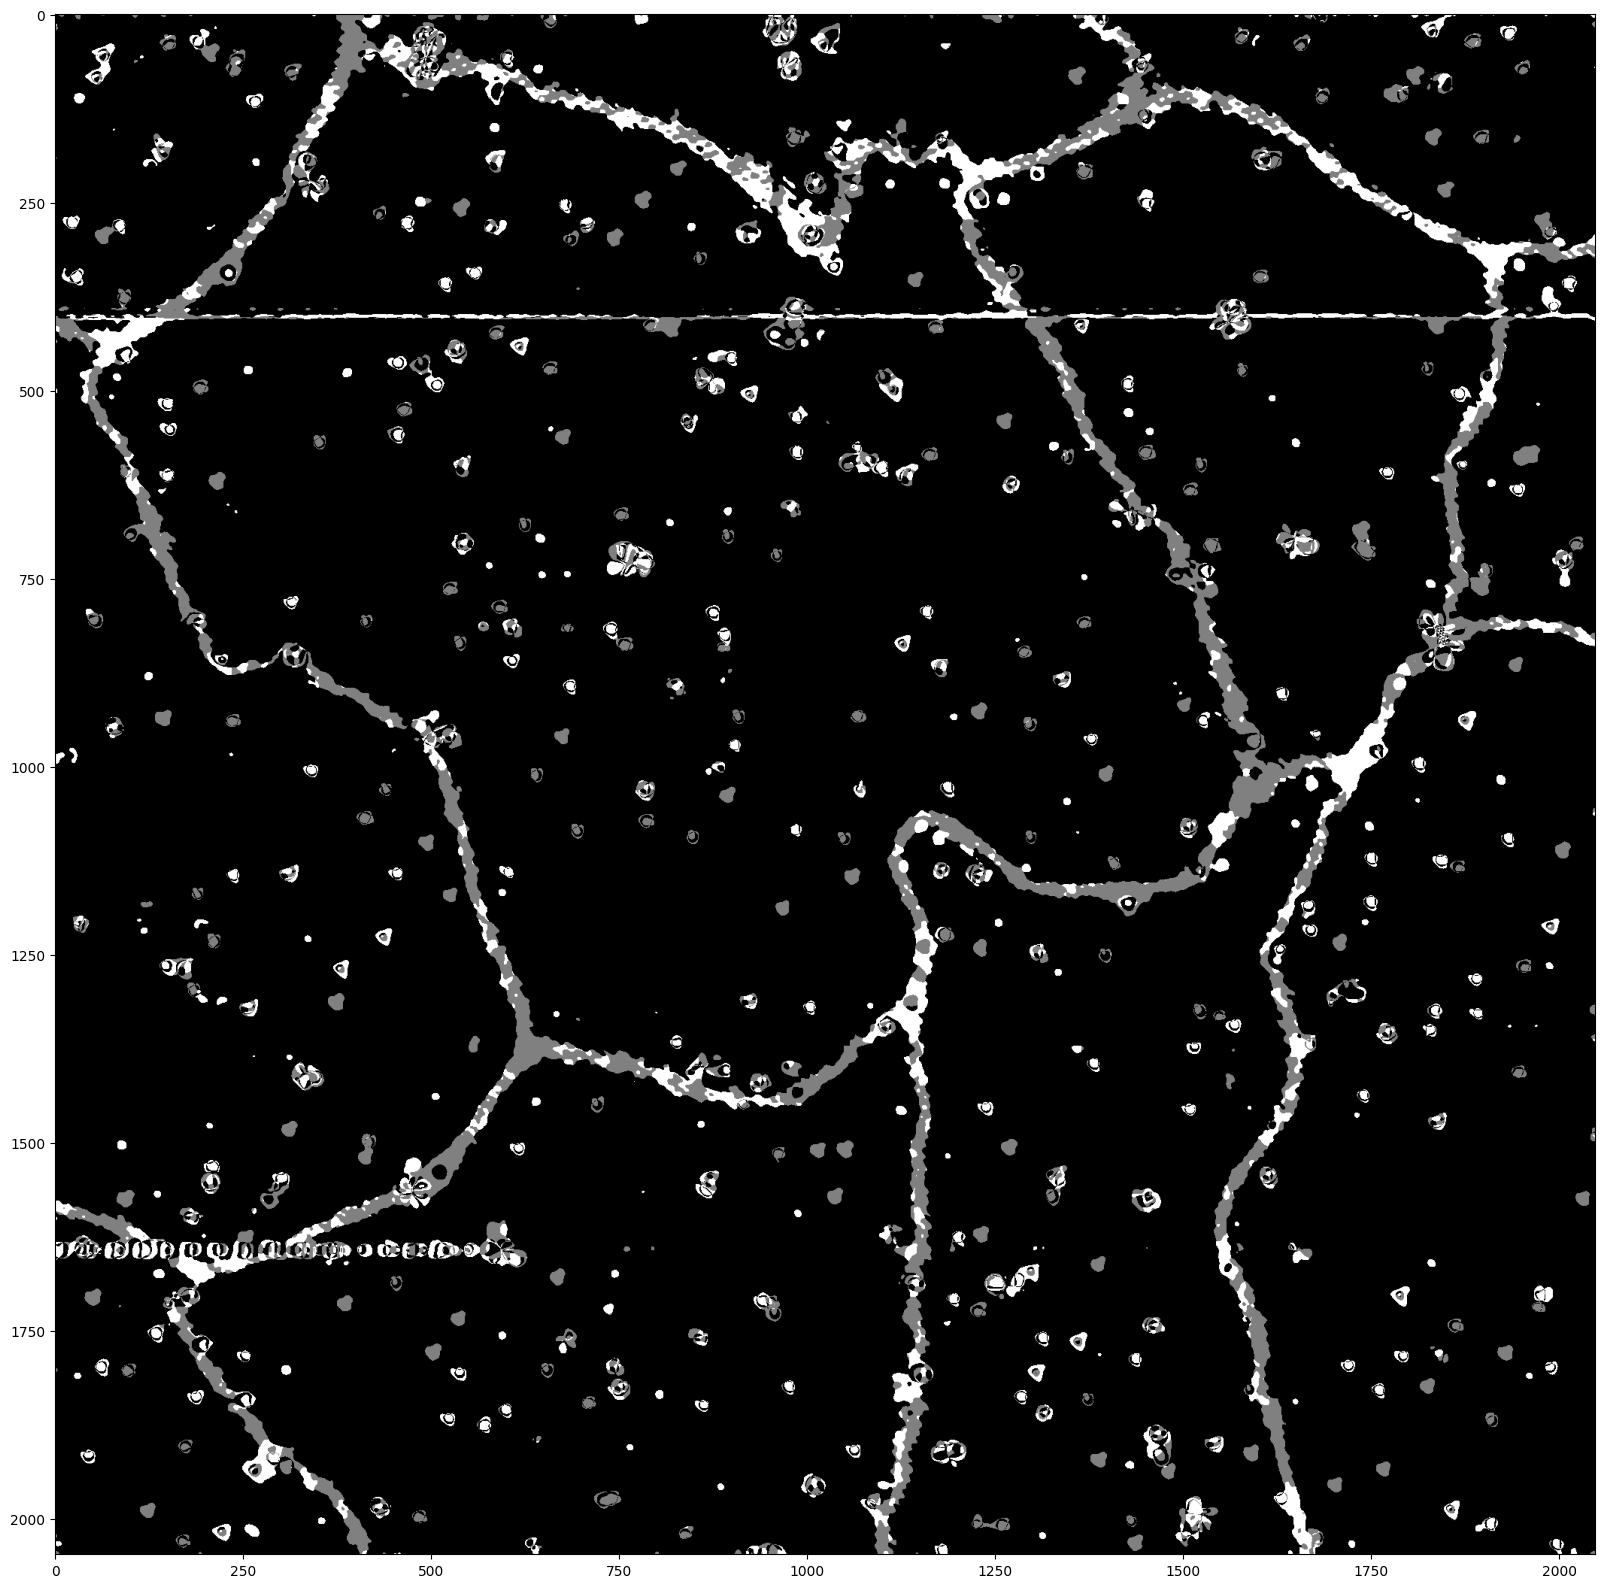

In [ ]:
HAC_holder = Info2[1]
HAC_argmax = np.argmax(HAC_holder, axis=2)
fig = plt.figure(figsize=(20,20))
plt.imshow(HAC_argmax,cmap='gray')

In [ ]:
HAC_holder[0].shape

(2048, 3)

In [ ]:
def get_z3z3hex(Info):
  HHH_argmax = np.argmax(Info[0], axis=2)
  mod01,mod10 = np.divmod(HHH_argmax ,2)
  hex1 = np.mod(Info[2][:,:,0] + mod10,3)
  hex2 = np.mod(Info[2][:,:,1] + mod01,3)
  z3z3hex = np.stack((hex1,hex2),axis=2)
  return z3z3hex

In [ ]:
z3z3hex = get_z3z3hex(Info2)

In [ ]:
colors = {
    "Red Bright": (1.0, 0.302, 0.302),   # #FF4D4D
    "Red Dark":   (0.478, 0.110, 0.110), # #7A1C1C
    "Green Bright": (0.302, 1.0, 0.302), # #4DFF4D
    "Green Dark":   (0.110, 0.478, 0.110), # #1C7A1C
    "Blue Bright":  (0.302, 0.58, 1.0),  # #4D94FF
    "Blue Dark":    (0.110, 0.110, 0.478) # #1C1C7A
}

In [ ]:
p_00 = [.5,.5,.5]
p_12 = [.1,.1,.1]
p_21 = [.8,.8,.8]

p_10 = colors["Red Dark"]
p_01 = colors["Green Dark"]
p_22 = colors["Blue Dark"]

p_20 = colors["Red Bright"]
p_02 = colors["Green Bright"]
p_11 = colors["Blue Bright"]

In [ ]:
clrset = [[p_00,p_01,p_02],[p_10,p_11,p_12],[p_20,p_21,p_22]]
clrset = np.array(clrset)
clrset.shape

(3, 3, 3)

In [ ]:
shp = z3z3hex.shape
phase9 = np.zeros((shp[0],shp[1],3))
for ix  in range(shp[0]):
  for iy in range(shp[1]):
    phase9[ix,iy,:] = clrset[int(z3z3hex[ix,iy,0]),int(z3z3hex[ix,iy,1]),:]

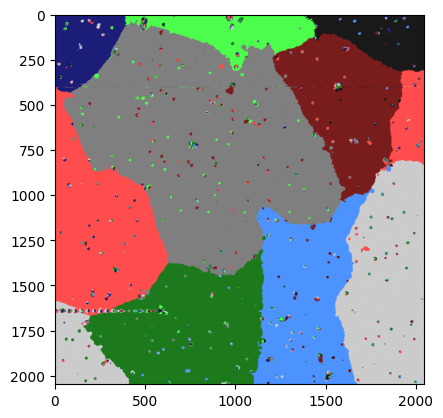

In [ ]:
plt.imshow(phase9)

In [ ]:
def getDWsegment(z6,is_close10):
  class6 = [210,201,120,102,21,12]
  blk = [1012,1102,120,210]
  rlk = [1120,1210,12,102]
  glk = [1021,1201,21,201]
  class12 = np.array([blk,rlk,glk])

  class6this = np.sum(z6*np.array([100,10,1]))
  z6 =  class6 == class6this
  class12this = class6this +1000*is_close10
  classified = class12 == class12this
  true_indices = np.where(classified)
  classified3 = true_indices[0][0]
  return classified3

In [ ]:
Info = Info2

In [ ]:
Z6 = Info[3]
Is_close10 = Info[0][:,:,2]>0

# ix,iy= 93,22

classified3s = np.zeros(Z6.shape[0:2])
for ix in range(Z6.shape[0]):
  for iy in range(Z6.shape[1]):
    z6 = Z6[ix,iy,:]# input 1
    is_close10 = Is_close10[ix,iy]# input 2
    classified3 = getDWsegment(z6,is_close10)
    classified3s[ix,iy] = classified3

In [ ]:
classified3s_rgb = np.stack((classified3s==1,classified3s==0,classified3s==2),axis=2)

In [ ]:
DWThick = .2
dlt = DWThick

In [ ]:
dwBW = Info[1][:,:,0]<DWThick

In [ ]:
dw_rgb = classified3s_rgb * dwBW[:, :, np.newaxis]

In [ ]:
# Z3z3,Rphi12 =  z3z3split_vec(Phi1,Phi2)
Z3z3,Rphi12 = vp.z3z3split(Phi1,Phi2)
coefs = np.array([[-2/4,4/4],[1/2,1/2],[4/4,-2/4]])
# coefs.shape

In [ ]:
chiral = np.einsum('ijk,li->jkl', np.array(Rphi12), coefs)
chiral = chiral[:,:,[2,0,1]]
chiral[:,:,2] = -chiral[:,:,2]

In [ ]:
chiral_ = np.mod(chiral+dlt/2,.5)-dlt/2
chiral_ = -(1/dlt)*(chiral_-dlt/2)

In [ ]:
final = chiral_*dw_rgb

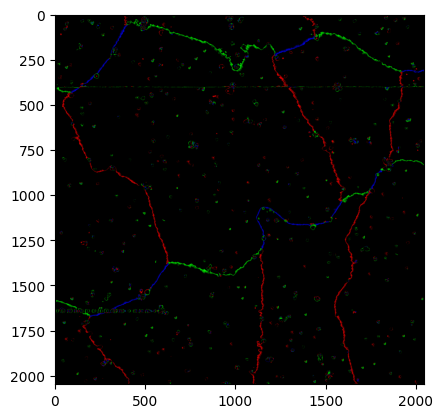

In [ ]:
plt.imshow(final)

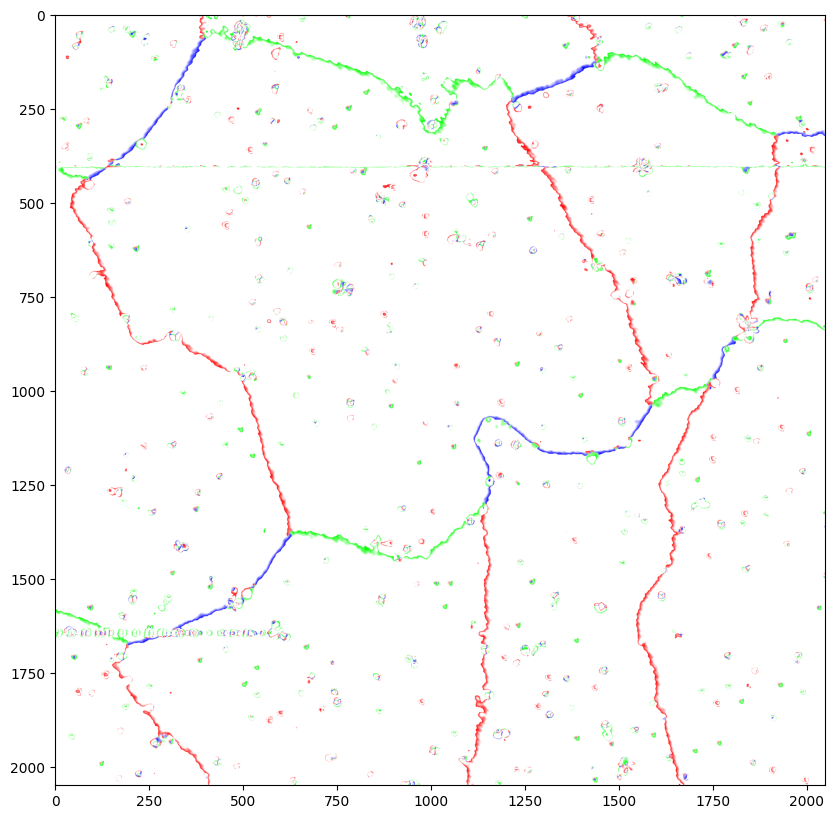

In [ ]:
from skimage.color import rgb2hsv,hsv2rgb
final2 = rgb2hsv(final)
final2[:,:,1] = final2[:,:,2]
final2[:,:,2] = 1
final2 = hsv2rgb(final2)
fig = plt.figure(figsize=(10, 10))
plt.imshow(final2.astype(np.float64))

In [ ]:
import numpy as np

def z3z3split_vec(phi1, phi2):
    phi1 = phi1 % (2*np.pi)
    phi2 = phi2 % (2*np.pi)
    phi1i = phi1 / (2*np.pi)
    phi2i = phi2 / (2*np.pi)
    z3z31, rphi1 = np.divmod(phi1i, 1/3)
    z3z32, rphi2 = np.divmod(phi2i, 1/3)
    z3z3 = np.stack([z3z31, z3z32], axis=-1)
    rphi12 = np.stack([rphi1*3, rphi2*3], axis=-1)
    return z3z3, rphi12

def rlsplit_vec(rphi12):
    is_close_10 = rphi12[...,0] > rphi12[...,1]
    # swap if not close
    rphi12_swapped = np.where(is_close_10[...,None], rphi12, rphi12[...,::-1])
    rphi12_C = np.stack([rphi12_swapped[...,0]-rphi12_swapped[...,1],
                         rphi12_swapped[...,1]], axis=-1)
    v_c1 = rphi12_C[...,0]
    v_c2 = rphi12_C[...,1]
    baryHHH_foo = np.stack([1-v_c1-v_c2, v_c1, v_c2], axis=-1)
    return is_close_10, baryHHH_foo

def sixsplit_vec(baryHHH_foo):
    z6 = np.argsort(baryHHH_foo, axis=-1)[...,::-1]
    p_BarHHH = np.take_along_axis(baryHHH_foo, z6, axis=-1)
    p_AffHHH = p_BarHHH[...,1:]
    I = np.array([[1,2],[1,-1]])
    p_AffHAC = np.einsum('ij,...j->...i', I, p_AffHHH)
    p_BarHAC = np.stack([1-p_AffHAC[...,0]-p_AffHAC[...,1],
                         p_AffHAC[...,0], p_AffHAC[...,1]], axis=-1)
    return z6, p_BarHAC

def get_baryHHH_vec(baryHHH_foo, is_close_10):
    out = np.zeros(baryHHH_foo.shape[:-1] + (4,))
    out[...,0] = baryHHH_foo[...,0]
    out[...,3] = baryHHH_foo[...,2]
    idx = (~is_close_10).astype(int)+1
    out[np.arange(out.shape[0])[:,None], np.arange(out.shape[1])[None,:], idx] = baryHHH_foo[...,1]
    return out

def get_baryHAC_vec(is_close_10, baryHAC_foo):
    baryHAC = baryHAC_foo.copy()
    swap_idx = np.array([0,2,1])
    baryHAC_swapped = baryHAC[...,swap_idx]
    return np.where(is_close_10[...,None], baryHAC, baryHAC_swapped)

def phaseInfo2_vec(Phi1, Phi2):
    z3z3, rphi12 = z3z3split_vec(Phi1, Phi2)
    is_close_10, baryHHH_foo = rlsplit_vec(rphi12)
    z6, baryHAC_foo = sixsplit_vec(baryHHH_foo)
    baryHHH = get_baryHHH_vec(baryHHH_foo, is_close_10)
    baryHAC = get_baryHAC_vec(is_close_10, baryHAC_foo)
    return baryHHH, baryHAC, z3z3, z6
